# Part 1: Genres and communities and plotting 

In [1]:
import json
import urllib.request
import re
import os
import networkx as nx
import numpy as np
from collections import defaultdict, Counter
import community as community_louvain  

#### Reading the artist file

In [7]:
# Read the .txt file and store it in a variable with keys and values
genres_data = json.load(open('artists_genres_dictionary.txt'))

# Print number of artists in the dictionary
print(f"Number of artists in the file: {len(genres_data)}")

# Display data
print(f"First 5 artists and its associated genres in the file: {list(genres_data.items())[:5]}")

Number of artists in the file: 1833
First 5 artists and its associated genres in the file: [('A Thousand Horses', ['country', 'country rock', 'southern rock']), ('A.P. Carter', ['country', 'folk', 'gospel']), ('Aaron Barker', ['country']), ('Aaron Benward', ['country', 'christian music']), ('Aaron Lewis (musician)', ['alternative metal', 'post-grunge', 'nu metal', 'country rock', 'alternative country'])]


#### Downloading the wikipedia pages of the 1833 artists in the file

In [8]:
# Lets use wikipedia API to get the page of the artists
def get_wiki(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat = "format=json"
    
    # URL-encode the title to handle spaces and special characters
    title = "titles={}".format(urllib.parse.quote(title))
    
    # Build the query URL
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    # Make the request to Wikipedia API
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    
    # Decode and return the JSON data
    wikitext = wikidata.decode('utf-8')
    return json.loads(wikitext)

def extract_page_content(wiki_data):
    try:
        # Get the page key (pageid) dynamically (since page IDs can vary)
        page = list(wiki_data['query']['pages'].values())[0]
        return page['revisions'][0]['*']  # Return the raw page content
    except KeyError:
        return None  # In case there's no content found
    
# Function to format a valid filename from an artist name
def format_filename(artist_name):
    # Remove characters that are invalid for filenames on most systems
    return re.sub(r'[\\/*?:"<>|]', '', artist_name)

In [9]:
# Create a list of artist names
artist_names = list(genres_data.keys())

# Output directory for saving Wikipedia pages
output_dir = "wikipedia_pages"

# Loop through each artist, fetch their Wikipedia page, and save it
for artist in artist_names:
    # Format the filename and create the full path
    filename = format_filename(artist) + ".txt"
    file_path = os.path.join(output_dir, filename)

    # Check if the file already exists; if so, skip to the next artist
    if os.path.exists(file_path):
        continue

    # Query Wikipedia and retrieve page content if file does not exist
    wiki_data = get_wiki(artist)
    page_content = extract_page_content(wiki_data)
    
    if page_content:
        # Write the page content to a text file
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(page_content)
        print(f"Successfully saved Wikipedia page for {artist} to {file_path}") # Print success message if file is saved because the file did not exist
    else:
        print(f"Wikipedia page for {artist} does not exist or has no content.")

FileNotFoundError: [Errno 2] No such file or directory: 'wikipedia_pages\\A Thousand Horses.txt'

In [19]:
# Function to get the names of connected artists from the Wikipedia page content
def get_connected_names(content):
    # Find matches within [[...]]
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    
    # Clean up each match to standardize the format
    connected_names = []
    for match in matches:
        # Remove text within parentheses and after '|'
        name = re.sub(r'\(.*?\)|\|.*', '', match).strip()
        connected_names.append(name)
    
    return connected_names

# Function to filter out non-artist names from the artist_names list
def filter_connected_names(connected_names, singer_names):
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

# Function to count the number of words in a given content
def count_words(content):
    return len(re.findall(r'\b\w+\b', content))

# Function to create the graph
def create_map(folder_path, singer_names):
    # Convert folder path to absolute path
    folder_path = os.path.abspath(folder_path)
    
    # Initialize an undirected graph
    G = nx.Graph()

    for artist in singer_names:
        # Prepare file path
        artist_filename = format_filename(artist)
        file_path = os.path.join(folder_path, f"{artist_filename}.txt")

        # Skip if file does not exist
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        # Open and read content
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
        
        # Calculate content length if content is not empty
        content_length = count_words(content) if content else 0

        # Add artist as a node with content_length attribute
        G.add_node(artist, content_length=content_length)
        
        # Process and filter connected names for edge addition
        filtered_names = filter_connected_names(get_connected_names(content), singer_names)
        G.add_edges_from((artist, name) for name in filtered_names)
    
    return G

#### Network creation

In [20]:
folder_path = 'wikipedia_pages'  
G = create_map(folder_path, singer_names=artist_names)
G.remove_edges_from(nx.selfloop_edges(G))

# Print the number of nodes and edges in the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1833 nodes and 13467 edges.


#### Modularity

In [34]:
# Step 1: Copy the graph and set genres
G_genres_country = G.copy()
node_genres = {artist: (genres[0] if genres else 'unknown') for artist, genres in genres_data.items()}
nx.set_node_attributes(G_genres_country, node_genres, 'genre')

# Step 2: Create genre communities
genre_communities = defaultdict(list)
for node, genre in node_genres.items():
    genre_communities[genre].append(node)

# Step 3: Calculate modularity
def calculate_modularity(G, communities):
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    A = nx.to_numpy_array(G, nodelist=G.nodes())  # adjacency matrix
    L = G.number_of_edges()
    degrees = np.array([G.degree(node) for node in G.nodes()])

    modularity = 0.0
    for community in communities:
        indices = [node_to_index[node] for node in community]
        subgraph = A[np.ix_(indices, indices)]
        ki = degrees[indices]

        sum_Aij = np.sum(subgraph)
        sum_kikj = np.sum(np.outer(ki, ki)) / (2 * L)

        modularity += (sum_Aij - sum_kikj)

    return modularity / (2 * L)

# Step 4: Compute and print modularity
M = calculate_modularity(G_genres_country, genre_communities.values())
print("Modularity of the first genre (including country):", M)

Modularity of the first genre (including country): 0.07098935918585711


In [35]:
# Step 1: Copy the graph and assign genres
G_genres_without_country = G.copy()
node_genres = {
    artist: (next((g for g in genres if g != 'country'), 'country') if genres else 'unknown') # If genres is empty (genres is False), it returns "unknown". If genres is non-empty: It finds the first non-"country" genre, or defaults to "country" if all are "country"
    for artist, genres in genres_data.items()
}
nx.set_node_attributes(G_genres_without_country, node_genres, 'genre')

# Step 2: Group nodes by genre into communities
genre_communities = defaultdict(list)
for node, genre in node_genres.items():
    genre_communities[genre].append(node)

# Step 3: Calculate modularity
M = calculate_modularity(G_genres_without_country, genre_communities.values())
print("Modularity of the graph (ignoring 'country' as primary genre if other genres exist):", M)

Modularity of the graph (ignoring 'country' as primary genre if other genres exist): 0.08335525519068315


#### Louvain algorithm

In [ ]:
# Detect communities using the Louvain algorithm
def detect_communities_louvain(G):
    # Apply Louvain algorithm to find communities
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    return partition, modularity

# Main execution
# Detect communities and calculate modularity
# With country
partition, louvain_modularity = detect_communities_louvain(G_genres_country)
print(f"Modularity of the first genre (including country): {louvain_modularity:.4f}")

Modularity of the first genre (including country): 0.3812
Louvain Modularity (ignoring 'country' as primary genre if other genres exist): 0.3914


#### Network writing for visualizing in Grephi software

In [45]:
# Writing of the network ignoring 'country' as primary genre if other genres exist
nx.write_gexf(G_genres_without_country, 'artist_without_next_gender_notcountry_network.gexf')

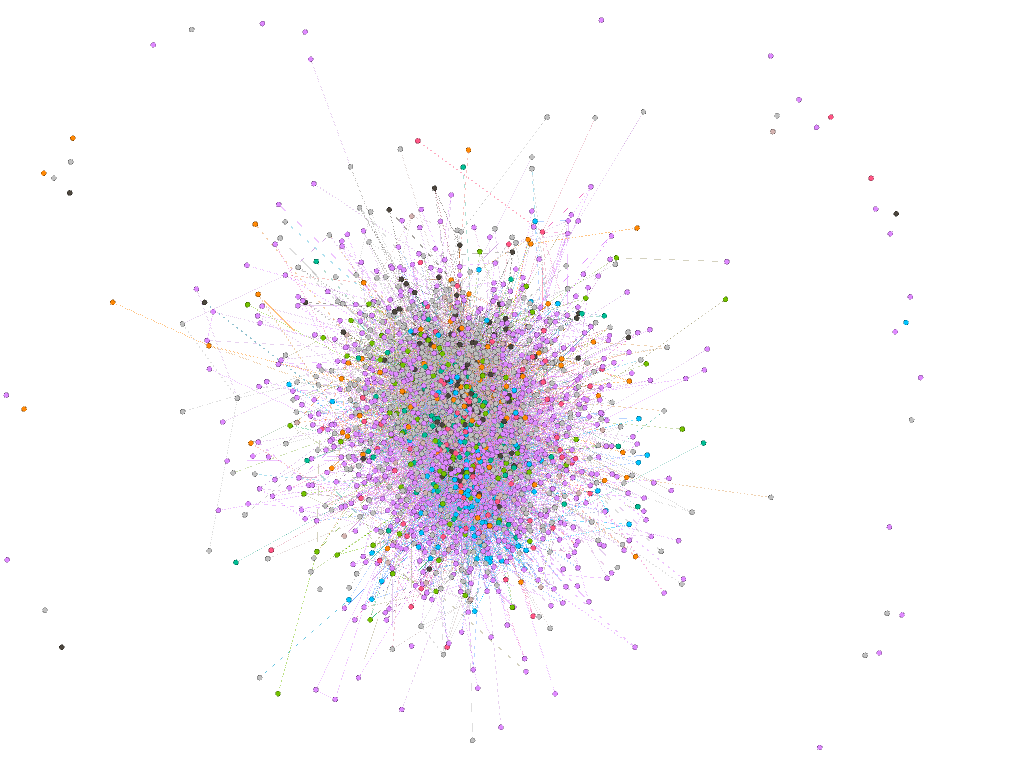
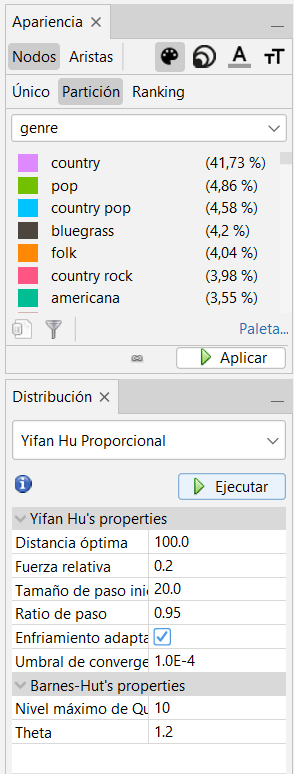


In [46]:
# Select the first 7 categories that are not unknown in the gender atribute
categories = [category for category in Counter(node_genres.values()).keys() if category != 'country'][:7]

# Create a dictionary with the categories as keys and the nodes as values
category_nodes = {category: [node for node, genre in node_genres.items() if genre == category] for category in categories}

# Create a subgraph with the nodes of the first 7 categories
G_category = G_genres_without_country.subgraph([node for nodes in category_nodes.values() for node in nodes])

# Detect communities and calculate modularity
partition_category, louvain_modularity_category = detect_communities_louvain(G_category)

# Write the network data to a GEXF file
nx.write_gexf(G_category, 'artist_7_category_wo_country_network.gexf')

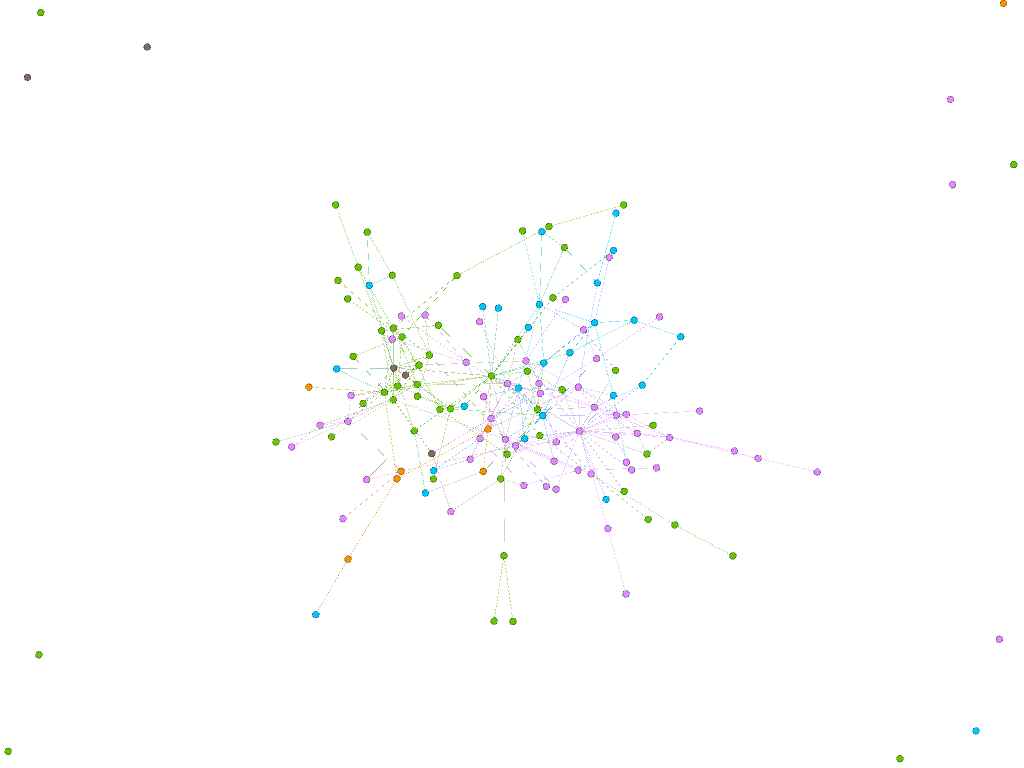 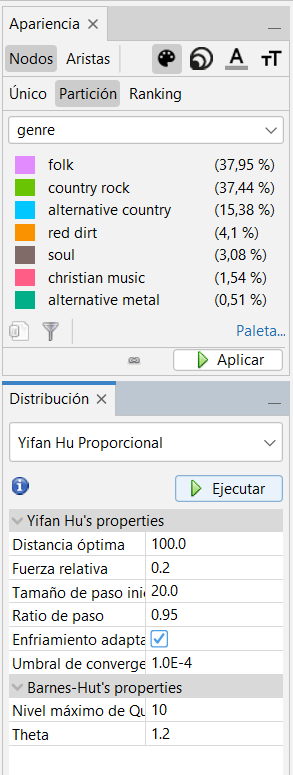